In [18]:
### import all the required libraries

import numpy as np
import matplotlib.pyplot as pl
import numpy as np
import imageio
import os
import pandas as pd

In [19]:
import matplotlib
%matplotlib notebook

In [4]:
### provide the path where the .tif file and .csv file are present
# os.chdir('/Volumes/GoogleDrive/My Drive/Grad_School_Year_2/Teaching/NEU350_Teaching/Optimized_codes_for_NEU350/Two_photon')
os.chdir('.')

In [5]:
### reading the .tif file

volim = imageio.volread('fish019_movingBarsLtoR.tif')

### Note that this data has two channels: Green and Red. The red channel doesn't have any data

TiffPages: failed to load virtual frames: page offsets not equidistant


In [6]:
print('The shape of the data is: ', np.shape(volim))
print('i.e. there are 1000 planes with dimension 64 x 256')

The shape of the data is:  (1000, 64, 256)
i.e. there are 1000 planes with dimension 64 x 256


### Let us now plot the data in green channel (which has calcium activity data). The data is an array of 64 x 256 values

<IPython.core.display.Javascript object>


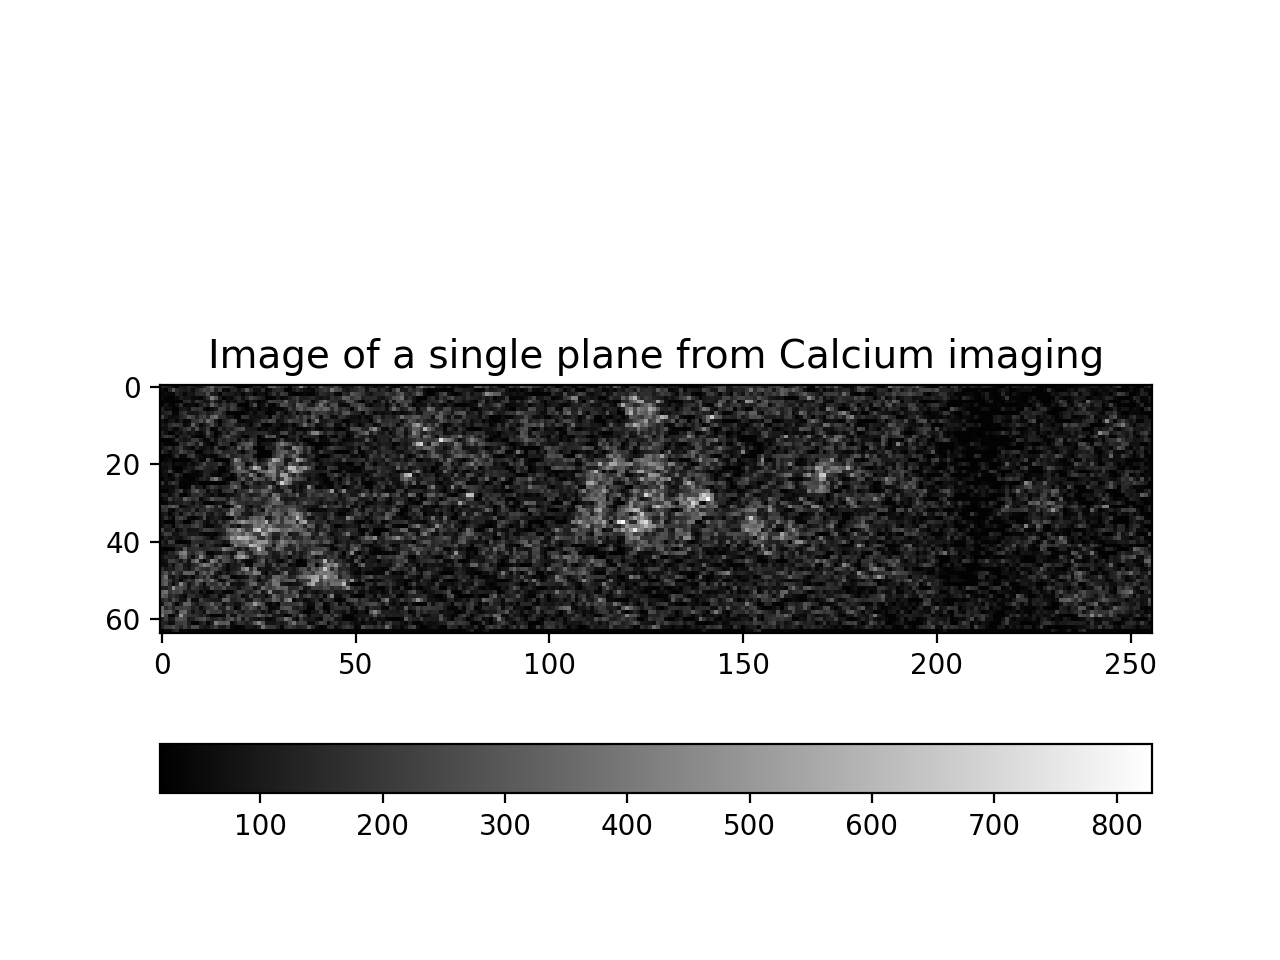

In [7]:
fish_data=volim[0:1000:2,:,:]  ### We are collecting data from only the green channel (and hence 2 is used to index)

### Let's plot just one frame of the green channel for visualization
pl.imshow(fish_data[320,:,:],cmap='gray') ### plotting frame 320 out of 500 in this dataset
pl.title('Image of a single plane from Calcium imaging',fontsize=14)
pl.colorbar(orientation='horizontal')
pl.show()

### Let us plot mean calcium activity. This will help us find neurons which were active during this recording

<IPython.core.display.Javascript object>


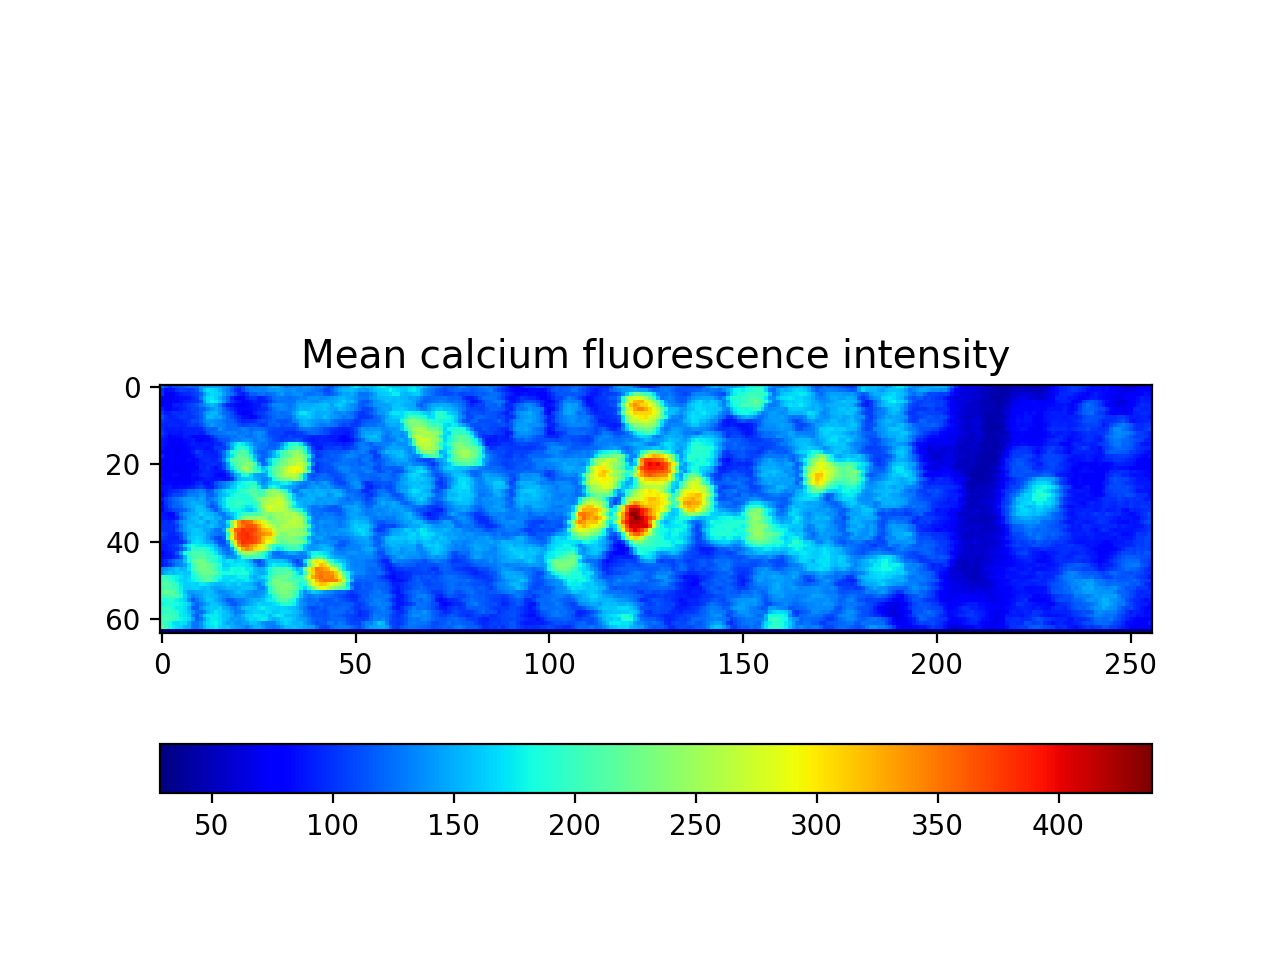

In [8]:
mean_fish_data=np.mean(fish_data,axis=0)  ### taking mean

## Can you guess the size of the variable "mean_fish_data"?

### plotting mean calcium activity. 
figure,ax=pl.subplots()
pl.imshow(mean_fish_data, cmap='jet')
pl.title('Mean calcium fluorescence intensity',fontsize=14)
pl.colorbar(orientation='horizontal')
pl.show()

## You can see different neurons which were active during the recording from the above plot.  

In [44]:
#### let us now load the data from the .csv file generated from the ImageJ or Fiji

## this block loads files from the csv files including the red channel and processed according to 
## the tutorial video.  we will update this code to pull in data without need for preprocessing.

raw_data = pd.read_csv('sample_ROIs.csv')   #### At this step you give the input .csv file.


num_of_ROIs = int(len(raw_data.columns)/4)
    
col_list = [(ROI*4) + 2 for ROI in range(num_of_ROIs)]

mean_fluor = raw_data.iloc[:,col_list]  # still a dataframe

calcium_activity_data = mean_fluor.values #raw numbers

print(calcium_activity_data)

    
    # csv_data = raw_data.values 

# number_of_ROIs = 



[[170.255 244.452 174.938 342.97  767.808]
 [165.294 227.143 171.406 310.424 804.538]
 [164.588 252.952 193.578 359.424 841.058]
 ...
 [370.294 314.429 273.969 200.606 317.115]
 [375.216 357.69  249.312 205.667 318.788]
 [353.941 353.762 266.609 179.182 309.923]]


## Let us now plot the calcium activity traces which we pulled out from the .csv files

<IPython.core.display.Javascript object>


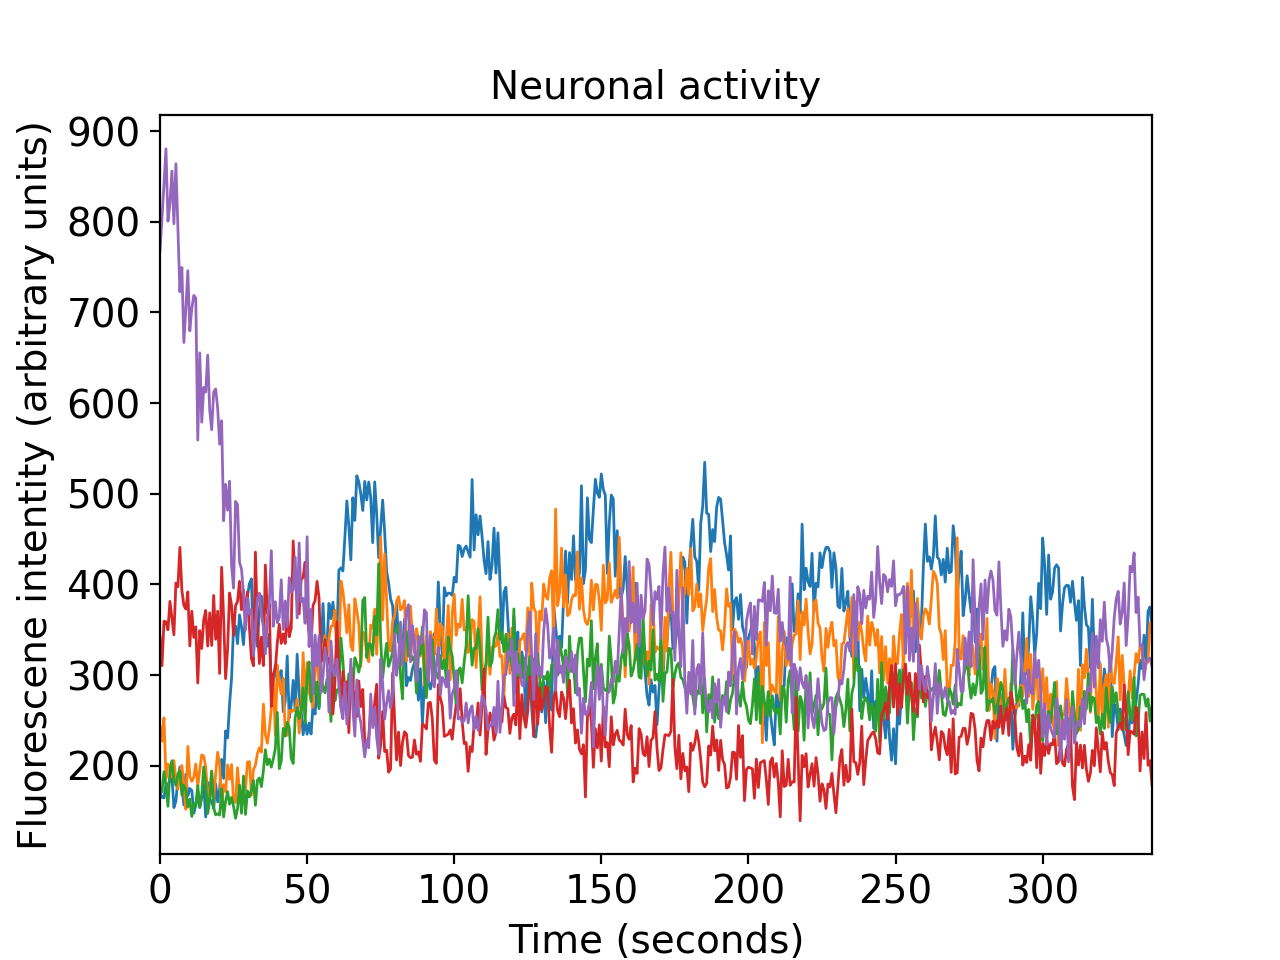

In [45]:
sampling_rate=1.48  ### This recording was done at 1.48 Hz. This informtion will help us get the time information
                    ### Remeber for crayfish recorings the sampling_rate was 10000?
    
x_axis=np.arange(np.shape(calcium_activity_data)[0]) 
x_axis=x_axis/sampling_rate    ### x_axis is now in the units of seconds

fig,ax=pl.subplots()

for data in np.arange(np.shape(calcium_activity_data)[1]):
    pl.plot(x_axis,calcium_activity_data[:,data],linewidth=1)
    
pl.xlabel('Time (seconds)',fontsize=14)
pl.ylabel('Fluorescene intentity (arbitrary units)',fontsize=14)
pl.title('Neuronal activity',fontsize=14)
pl.autoscale(enable=True, axis='x', tight=True)
pl.tick_params(labelsize=14)

### By looking at the (busy) figure above, it is difficult to get an idea about different group of neurons and their firing patterns. A good way to visualize is through correlation coefficient matrix. The correlation coefficient for two perfectly correlated neurons is 1, while it is -1 for perfectly anti-correlated neurons.

<IPython.core.display.Javascript object>


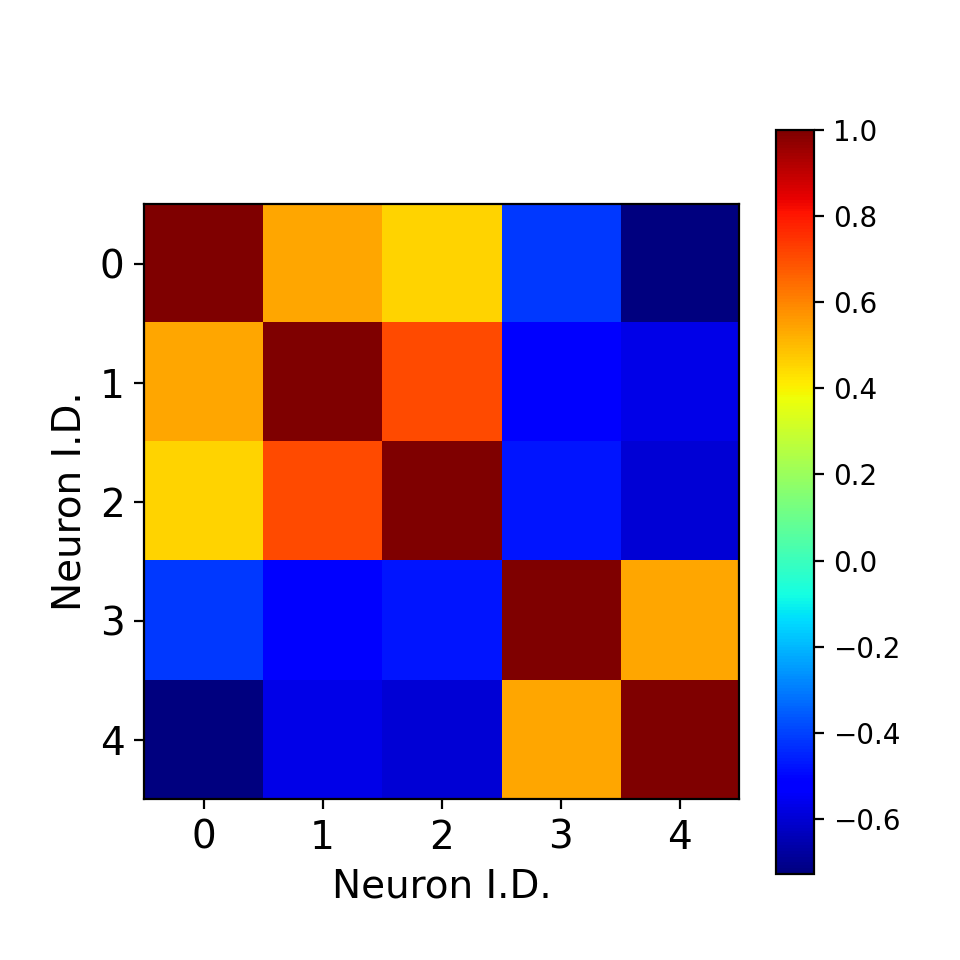

In [46]:
### Let us now generate correlation coefficient matrix and plot it

corr_coef_matrix=np.corrcoef(calcium_activity_data.T)  ## calculating correlation coefficient
pl.matshow(corr_coef_matrix,cmap='jet') ## matshow enables us to beautifully display the correlation coeff matrix
pl.colorbar()
pl.show()
pl.ylabel('Neuron I.D.',fontsize=14)
pl.xlabel('Neuron I.D.',fontsize=14)
pl.tick_params(labelbottom=True,labeltop=False)
pl.tick_params(labelsize=14)

### This step is to get rid of x-ticks from the top x-axis
pl.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

## How many group of distinct neuronal activity patterns which you can see? Two?

<IPython.core.display.Javascript object>


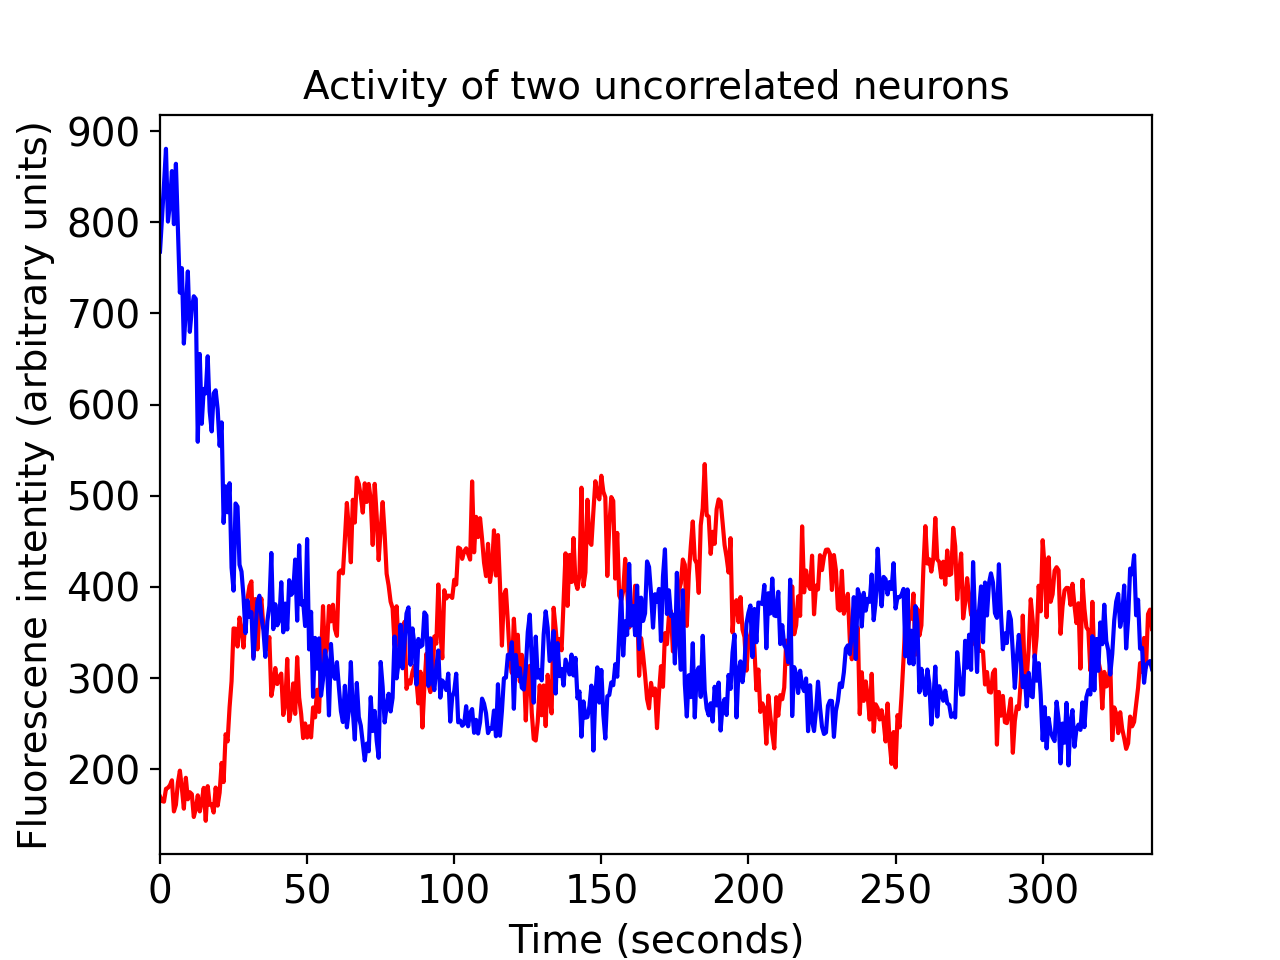

In [51]:
### There are two groups of neurons as seen in this dataset using imagej. Let us now plot them.

fig,ax=pl.subplots()
pl.plot(x_axis,calcium_activity_data[:,0],'-r')  ### from group 1 (0-2)
pl.plot(x_axis,calcium_activity_data[:,4],'-b')  ### from group 2 (3-4)
pl.xlabel('Time (seconds)',fontsize=14)
pl.ylabel('Fluorescene intentity (arbitrary units)',fontsize=14)
pl.title('Activity of two uncorrelated neurons',fontsize=14)
pl.autoscale(enable=True, axis='x', tight=True)
pl.tick_params(labelsize=14)

### The above figure shows two anti-correlated neurons. But it is very noisy. Let us re-plot the same data after filtering it using Savitzky–Golay_filter (https://en.wikipedia.org/wiki/Savitzky–Golay_filter)

<IPython.core.display.Javascript object>


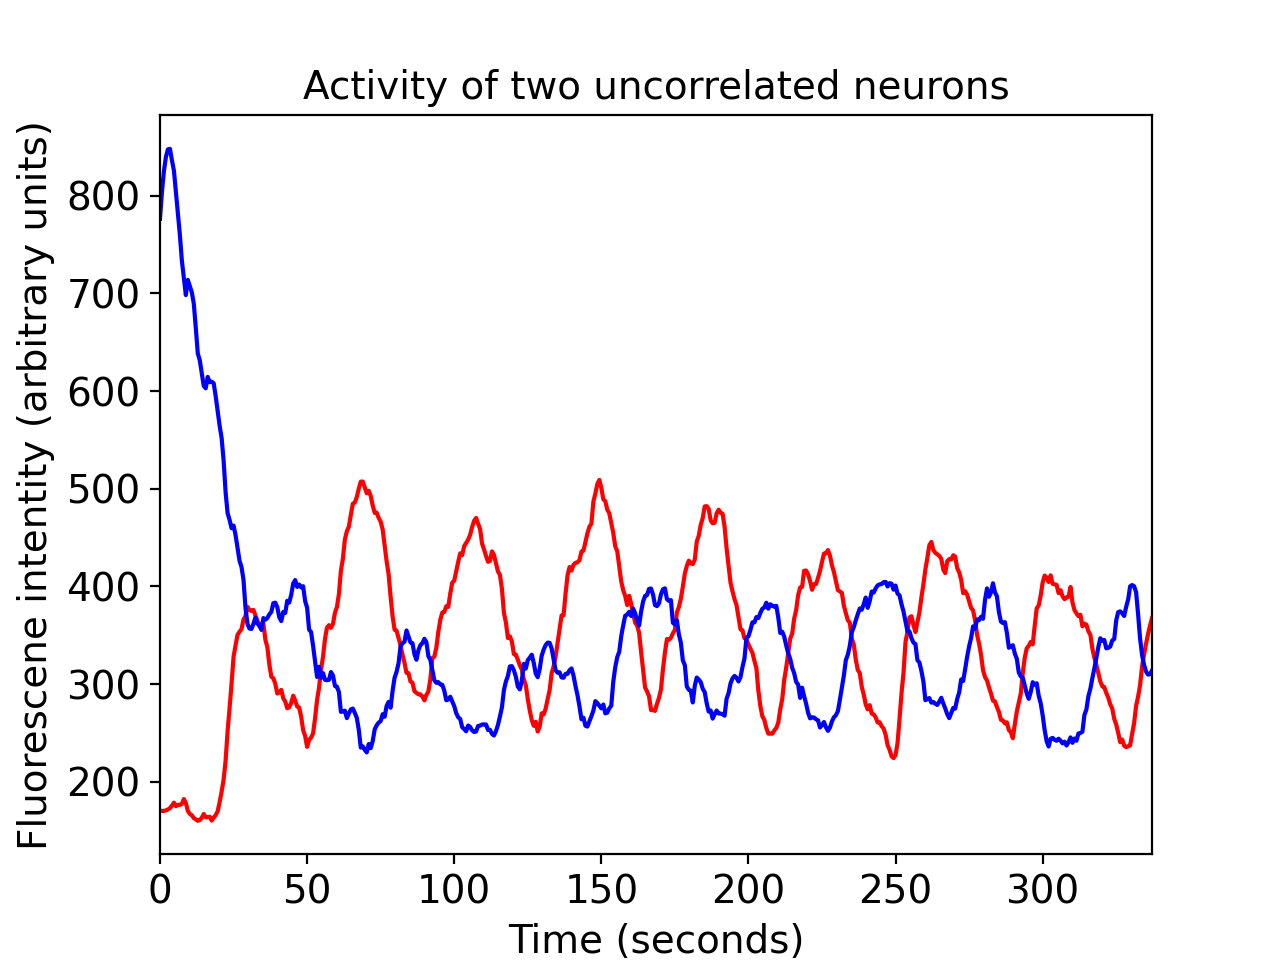

In [52]:
from scipy.signal import savgol_filter ### importing savgol_filter
## savgoal filter requires two additional information: window size (it must be an odd number) and polynomial order
## Here I am using a window size of 11 and fitting a second order polynomial

fig,ax=pl.subplots()
pl.plot(x_axis,savgol_filter(calcium_activity_data[:,0], 11, 2),'-r')  ### from group 1 (anything between 0-3)
pl.plot(x_axis,savgol_filter(calcium_activity_data[:,4], 11, 2),'-b')  ### from group 2 (anything between 4-5)
pl.xlabel('Time (seconds)',fontsize=14)
pl.ylabel('Fluorescene intentity (arbitrary units)',fontsize=14)
pl.title('Activity of two uncorrelated neurons',fontsize=14)
pl.autoscale(enable=True, axis='x', tight=True)
pl.tick_params(labelsize=14)

## Many a times in research, we are not interested in absolute value of fluorescence. We are interested in studying the increase in fluorescence with respect to baseline. Thus, you will see a variable known us Delta F over F in research papers.
## Delta F over F = (F_stim - F_baseline)/F_baseline

### One of the standard methods to calculate F_baseline is to use the lower 8th percentile of the data

In [53]:
##### let us calculate delta F over F for one neuron as an example

data_to_be_plotted=calcium_activity_data[:,0] ## plotting deltaF_overF for neuron 0

## calculating the value of lower 8th percentile of data
eight_percentile_data=np.percentile(data_to_be_plotted,8) 
print('8th percentile of this data is :', eight_percentile_data)

delta_F_over_F=(data_to_be_plotted-eight_percentile_data)/eight_percentile_data

8th percentile of this data is : 228.55192


## Let us now plot Delta_F_over_F

<IPython.core.display.Javascript object>


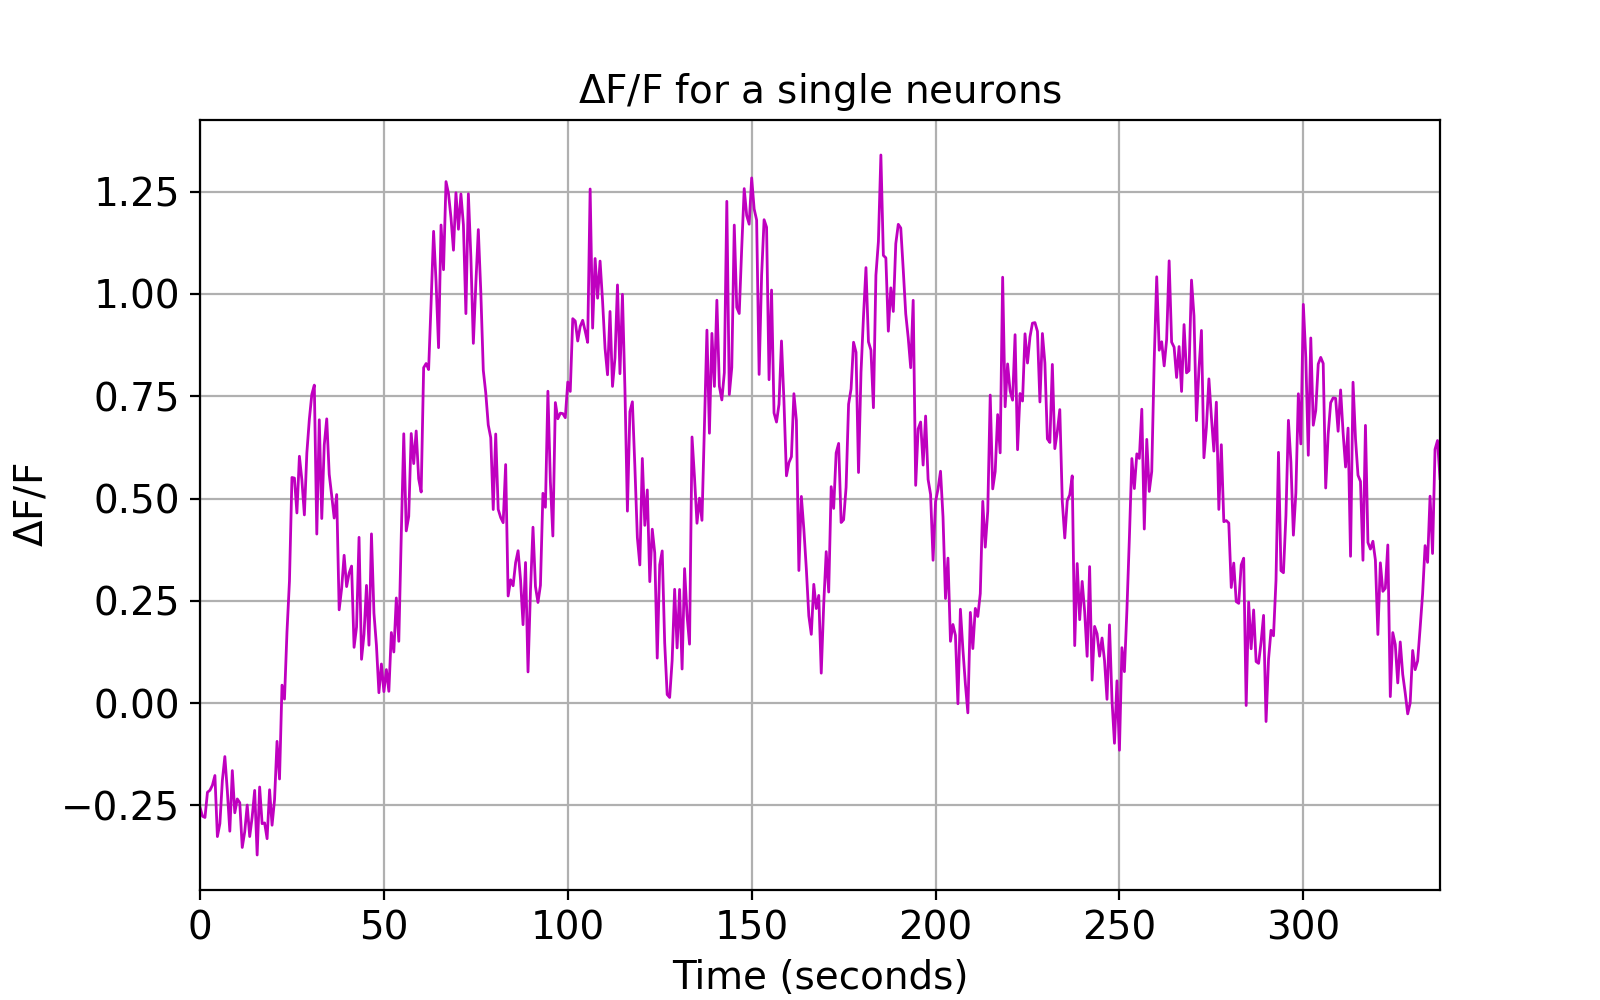

In [54]:
fig,ax=pl.subplots(figsize=(8,5))
pl.plot(x_axis,delta_F_over_F,'-m',linewidth=1)
pl.xlabel('Time (seconds)',fontsize=14)
pl.ylabel(r'$\Delta$F/F',fontsize=14)
pl.title(r'$\Delta$F/F for a single neurons',fontsize=14)
pl.grid(True) 
pl.autoscale(enable=True, axis='x', tight=True)
pl.tick_params(labelsize=14)

## Let us now calculate delta F over F for the complete dataset in the .csv file

<IPython.core.display.Javascript object>


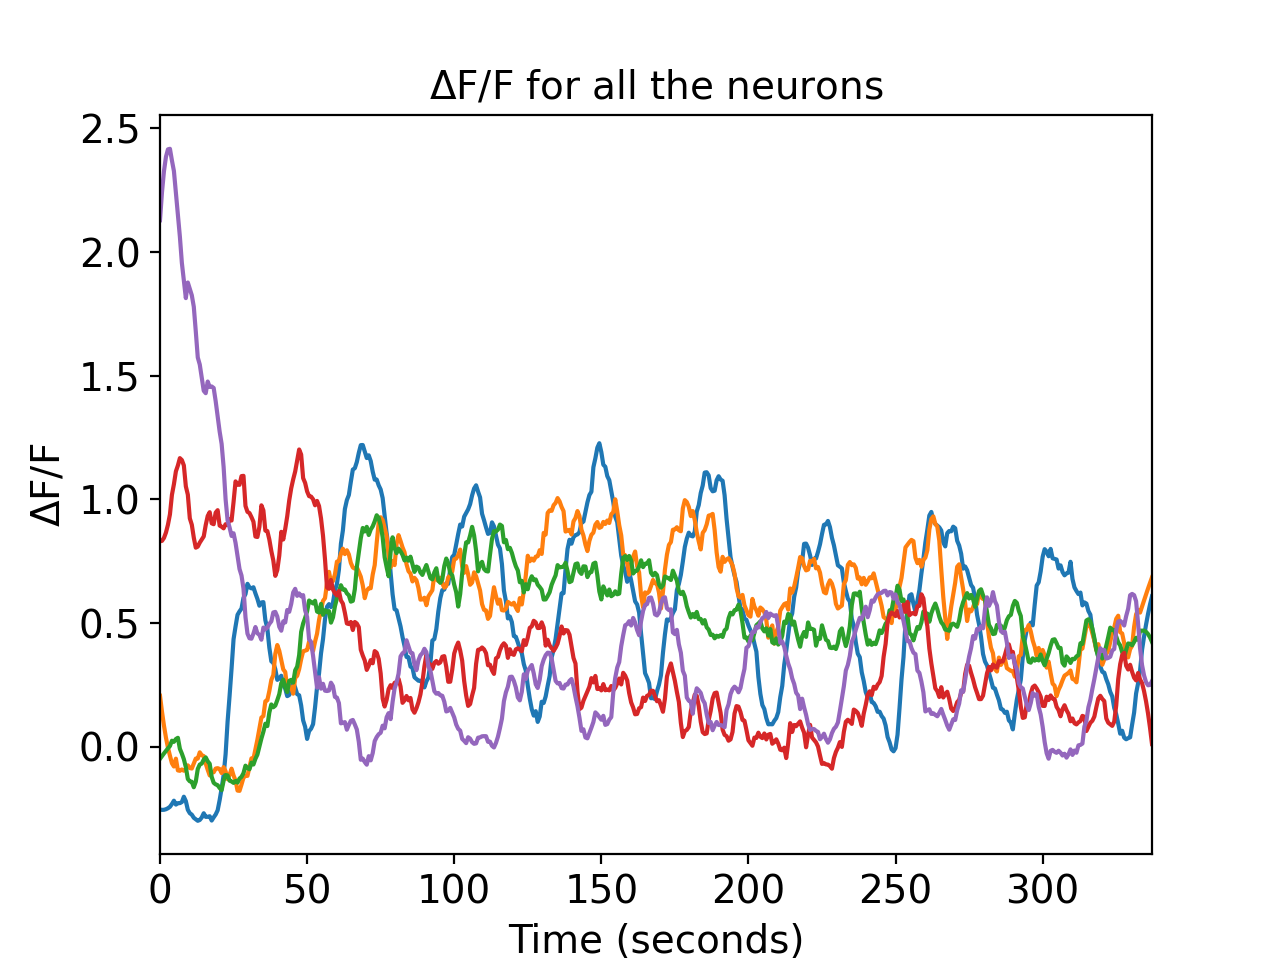

In [56]:
delta_F_over_F_matrix= np.empty(np.shape(calcium_activity_data)) ## Initializing the 

fig,ax=pl.subplots()
for data in np.arange(np.shape(calcium_activity_data)[1]):
    data_to_be_plotted=calcium_activity_data[:,data]
    eight_percentile_data=np.percentile(data_to_be_plotted,8)

    delta_F_over_F=(data_to_be_plotted-eight_percentile_data)/eight_percentile_data
    delta_F_over_F_matrix[:,data]=delta_F_over_F
    
    pl.plot(x_axis,savgol_filter(delta_F_over_F,11,2),linewidth=1.5) ## smoothing the data using the savgol filter
    pl.xlabel('Time (seconds)',fontsize=14)
    pl.ylabel(r'$\Delta$F/F',fontsize=14)
    pl.title(r'$\Delta$F/F for all the neurons',fontsize=14)
    pl.autoscale(enable=True, axis='x', tight=True)
    pl.tick_params(labelsize=14)

## It is very difficult to interpret the data by looking at the above plot which has so many traces. Another better tool to analyze such data is to use heatmap

<IPython.core.display.Javascript object>


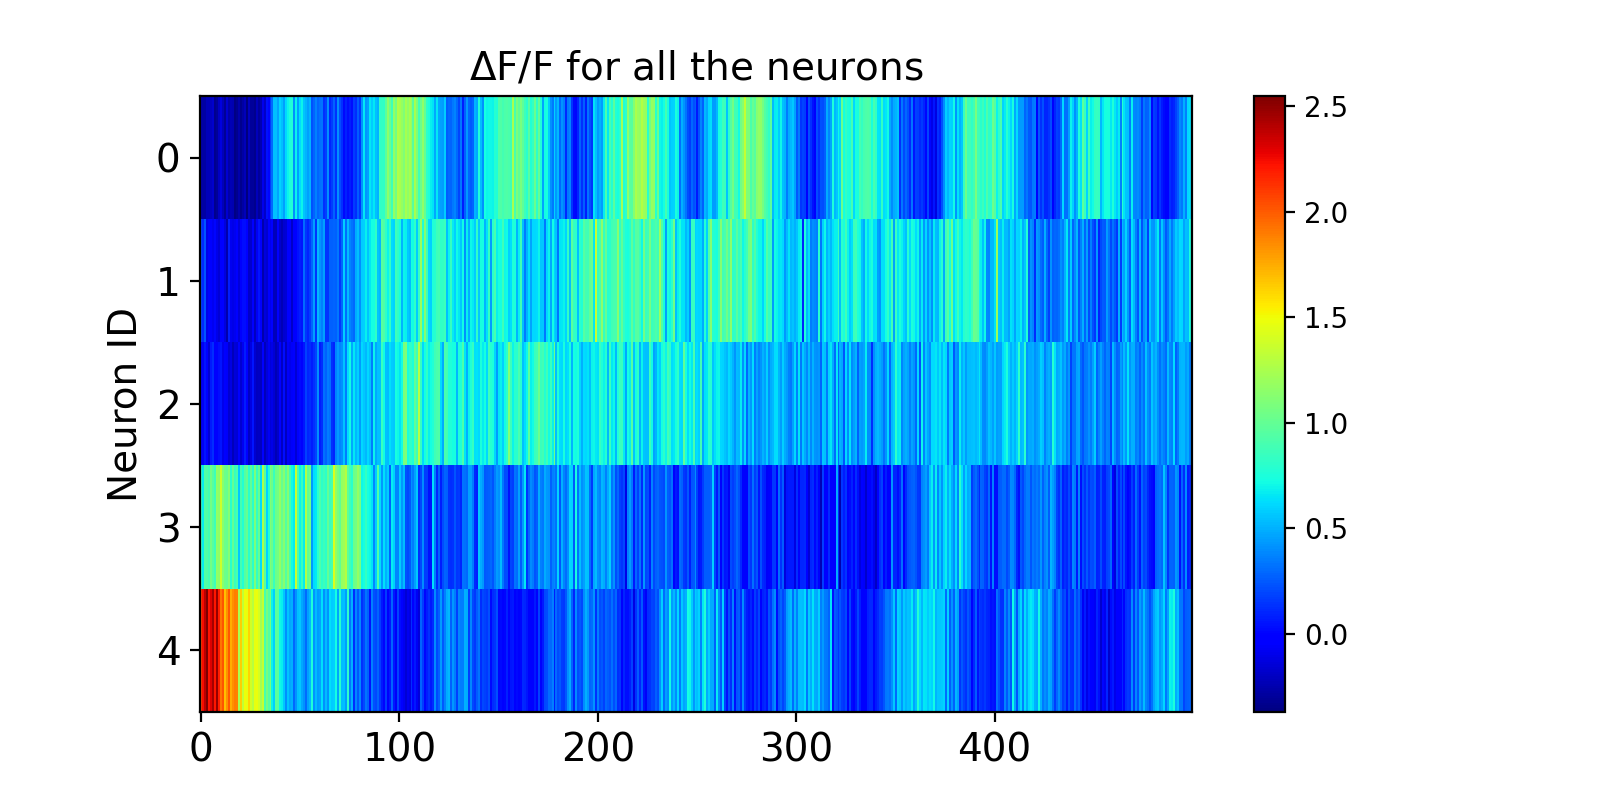

In [57]:
fig,ax = pl.subplots(figsize=(8, 4))
im=ax.imshow(delta_F_over_F_matrix.T, interpolation='nearest',cmap='jet')
ax.set_aspect('auto')
pl.colorbar(im);
pl.show()
# pl.xlabel('Time (seconds)',fontsize=14)
pl.ylabel('Neuron ID',fontsize=14)
pl.title(r'$\Delta$F/F for all the neurons',fontsize=14)
pl.grid(False) 
pl.autoscale(enable=True, axis='x', tight=True)
pl.tick_params(labelsize=14)